### Notebook for the processing and exploratory analysis of the [10X Genomics Xenium Breast Cancer](https://www.10xgenomics.com/products/xenium-in-situ/human-breast-dataset-explorer) data. 

- **Developed by**: Carlos Talavera-López Ph.D
- **Würzburg Institute for Systems Immunology (WüSI) & Julius-Maximilian-Universität Würzburg**
- **Created**: 230619
- **Last modified**: 230619

### Load required packages

In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import squidpy as sq
import seaborn as sns
import matplotlib.pyplot as plt

### Set up wortking environment 

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'svg', fontsize = 8)

-----
anndata     0.9.1
scanpy      1.9.3
-----
PIL                 9.5.0
appnope             0.1.3
asciitree           NA
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cloudpickle         2.2.1
colorama            0.4.6
comm                0.1.3
cycler              0.10.0
cython_runtime      NA
cytoolz             0.12.0
dask                2023.6.0
dask_image          2023.03.0
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
docrep              0.3.2
entrypoints         0.4
executing           1.2.0
fasteners           0.17.3
h5py                3.8.0
hypergeom_ufunc     NA
igraph              0.10.4
imagecodecs         2023.1.23
imageio             2.31.1
importlib_resources NA
ipykernel           6.23.1
jedi                0.18.2
jinja2              3.1.2
joblib              1.2.0
kiwisolver          1.4.4
lazy_loader         NA
leidenalg           0.9.1
llvmlite            0.38.1
lz4                 4.3

### Read in Xenium dataset

In [3]:
adata = sc.read_10x_h5(
    filename="../../datasets/xenium/rep_1/outs/cell_feature_matrix.h5"
)
adata

reading ../../datasets/xenium/rep_1/outs/cell_feature_matrix.h5
 (0:00:00)


AnnData object with n_obs × n_vars = 167780 × 313
    var: 'gene_ids', 'feature_types', 'genome'

In [4]:
df = pd.read_csv(
    "../../datasets/xenium/rep_1/outs/cells.csv"
)
df.head()

,cell_id,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,total_counts,cell_area,nucleus_area
0,1,847.259912,326.191365,28,1,0,29,58.387031,26.642187
1,2,826.341995,328.031830,94,0,0,94,197.016719,42.130781
2,3,848.766919,331.743187,9,0,0,9,16.256250,12.688906
3,4,824.228409,334.252643,11,0,0,11,42.311406,10.069844
4,5,841.357538,332.242505,48,0,0,48,107.652500,37.479687


In [5]:
df.set_index(adata.obs_names, inplace=True)
adata.obs = df.copy()
adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()
adata.obs.head()

,cell_id,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,total_counts,cell_area,nucleus_area
1,1,847.259912,326.191365,28,1,0,29,58.387031,26.642187
2,2,826.341995,328.031830,94,0,0,94,197.016719,42.130781
3,3,848.766919,331.743187,9,0,0,9,16.256250,12.688906
4,4,824.228409,334.252643,11,0,0,11,42.311406,10.069844
5,5,841.357538,332.242505,48,0,0,48,107.652500,37.479687


### Perform basic QC analysis _á la Squidpy_

In [6]:
sc.pp.calculate_qc_metrics(adata, percent_top = (10, 20, 50, 150), inplace = True)

- Calculate percentage of control probes and control codewords

In [7]:
cprobes = (
    adata.obs["control_probe_counts"].sum() / adata.obs["total_counts"].sum() * 100
)
cwords = (
    adata.obs["control_codeword_counts"].sum() / adata.obs["total_counts"].sum() * 100
)
print(f"Negative DNA probe count % : {cprobes}")
print(f"Negative decoding count % : {cwords}")

Negative DNA probe count % : 0.08838749926953768
Negative decoding count % : 0.006644247962710972


- Plot distribution of total transcripts per cell, unique transcripts per cell, area of segmented cells and the ratio of nuclei area to their cells

<Axes: title={'center': 'Nucleus ratio'}, ylabel='Count'>

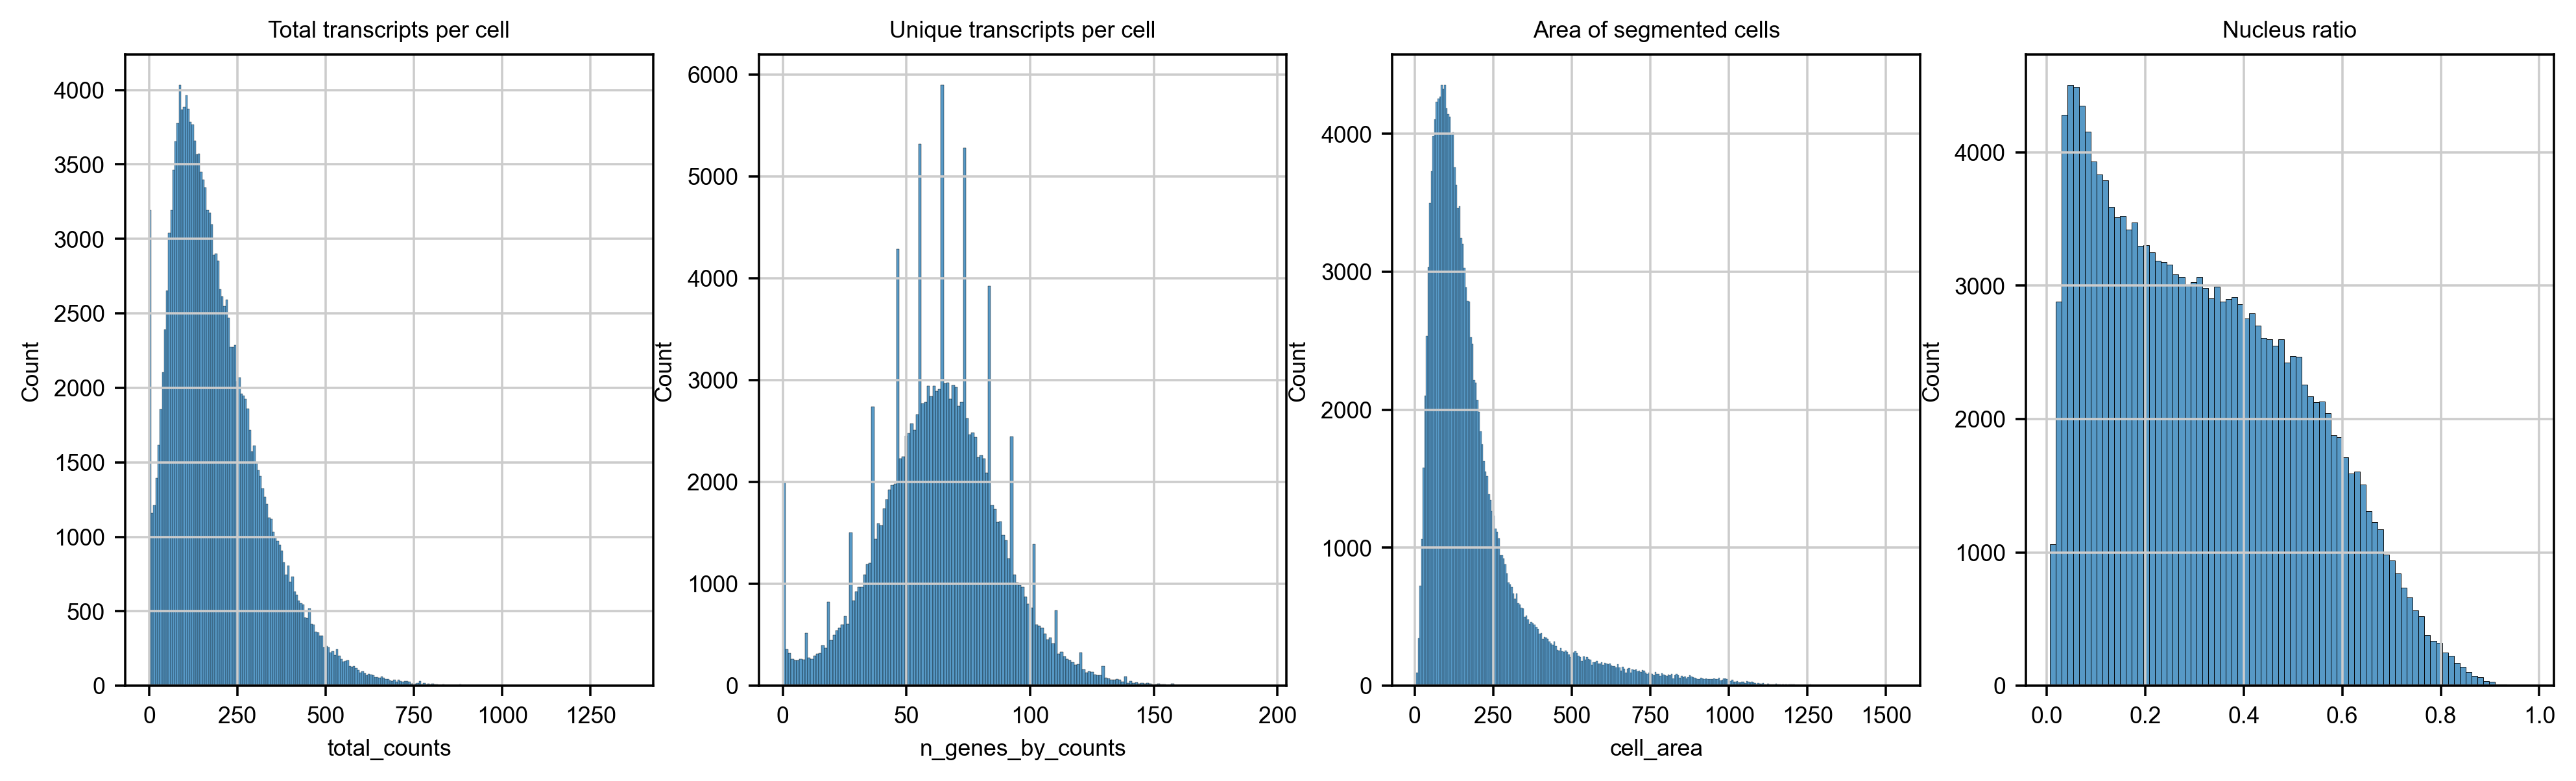

In [8]:
fig, axs = plt.subplots(1, 4, figsize = (15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    adata.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)


axs[2].set_title("Area of segmented cells")
sns.histplot(
    adata.obs["cell_area"],
    kde=False,
    ax=axs[2],
)

axs[3].set_title("Nucleus ratio")
sns.histplot(
    adata.obs["nucleus_area"] / adata.obs["cell_area"],
    kde=False,
    ax=axs[3],
)

### Filter out cells

In [9]:
sc.pp.filter_cells(adata, min_counts = 10)
sc.pp.filter_cells(adata, min_genes = 3)
sc.pp.filter_genes(adata, min_counts = 3)
sc.pp.filter_genes(adata, min_cells = 5)
adata

filtered out 3780 cells that have less than 10 counts


AnnData object with n_obs × n_vars = 164000 × 313
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    obsm: 'spatial'

### Normalise data and tranform data

In [10]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace = True, exclude_highly_expressed = True)
sc.pp.log1p(adata)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['ABCC11', 'ACTA2', 'ACTG2', 'ADAM9', 'ADGRE5', 'ADH1B', 'ADIPOQ', 'AGR3', 'AHSP', 'AIF1', 'AKR1C1', 'AKR1C3', 'ALDH1A3', 'ANGPT2', 'ANKRD28', 'ANKRD29', 'ANKRD30A', 'APOBEC3A', 'APOBEC3B', 'APOC1', 'AQP1', 'AQP3', 'AR', 'AVPR1A', 'BACE2', 'BANK1', 'BASP1', 'BTNL9', 'C15orf48', 'C1QA', 'C1QC', 'C2orf42', 'C5orf46', 'C6orf132', 'CAV1', 'CAVIN2', 'CCDC6', 'CCDC80', 'CCL20', 'CCL5', 'CCL8', 'CCND1', 'CCPG1', 'CCR7', 'CD14', 'CD163', 'CD19', 'CD1C', 'CD247', 'CD27', 'CD274', 'CD3D', 'CD3E', 'CD3G', 'CD4', 'CD68', 'CD69', 'CD79A', 'CD79B', 'CD80', 'CD83', 'CD86', 'CD8A', 'CD8B', 'CD9', 'CD93', 'CDC42EP1', 'CDH1', 'CEACAM6', 'CEACAM8', 'CENPF', 'CLCA2', 'CLDN4', 'CLDN5', 'CLEC14A', 'CLEC9A', 'CLECL1', 'CLIC6', 'CPA3', 'CRHBP', 'CRISPLD2', 'CSF3', 'CTH', 'CTLA4', 'CTSG', 'CTTN', 'CX3CR1', 'CXCL12', 'CXCL16', 'CXCL5', 'CXCR4', 'CYP1A1', 'CYTIP', 'DAPK3', 'DERL3', 'DMKN',

/Users/cartalop/mambaforge/envs/squidpy/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))
/Users/cartalop/mambaforge/envs/squidpy/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cartalop/mambaforge/envs/squidpy/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: Input contains NaN.